In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 9.1MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 8.0MB/s 


In [2]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-03-01 09:41:03--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-03-01 09:41:04--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc13467afce72a84818e7747e88a.dl.dropboxusercontent.com/cd/0/get/BJ3WlgtZSz_ESw0oqbeUisqm7tmQtewvgWk2f8xsgbep70d_oVNg0dAin0_hDxjpTkcBF-7aPW7H_8HR9BJEpHDTGHZiNhpYmYLsQgAFx2E55QD-0wsoENxDU3Qe3rgeZRo/file?dl=1# [following]
--2021-03-01 09:41:04--  https://uc13467afce72a84818e7747e88a.dl.dropboxusercontent.com/cd/0/get/BJ3WlgtZSz_ESw0oqbeUisqm7tmQtewvgWk2f8xsgbep70d_oVNg0dAin0_hDxjpTkcBF-7aPW7H_8HR9BJEpHDTGHZiNhpYmYLsQgAFx2E55QD-0wsoENxDU3Qe

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/no/
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_492637.jpg

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='hrnet_w40'),
]

In [9]:
import timm
timm.list_models('*hrnet_w40*')

['hrnet_w40']

In [10]:
learn = Learner(dls512, timm.models.hrnet.hrnet_w40(num_classes=2),cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-hrnet/hrnetv2_w40-7cd397a4.pth" to /root/.cache/torch/hub/checkpoints/hrnetv2_w40-7cd397a4.pth


SuggestedLRs(lr_min=0.15848932266235352, lr_steep=1.3182567358016968)

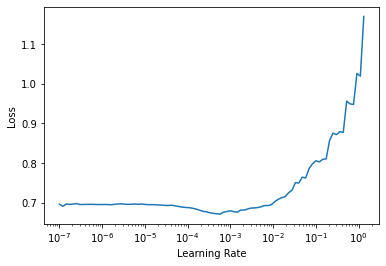

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.690414,0.676855,0.591743,0.581994,0.569182,01:13


Better model found at epoch 0 with valid_loss value: 0.6768553853034973.


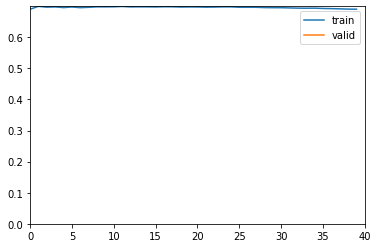

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.671336,0.672570,0.588685,0.563307,0.685535,01:13
1,0.664754,0.665648,0.608563,0.584699,0.672956,01:13
2,0.656357,0.656067,0.619266,0.590078,0.710692,01:13
3,0.642428,0.638280,0.652905,0.628169,0.701258,01:13
4,0.619623,0.608351,0.669725,0.644886,0.713836,01:13
5,0.585350,0.586989,0.691131,0.679012,0.691824,01:13
6,0.549489,0.567378,0.711009,0.710098,0.685535,01:13
7,0.519543,0.557197,0.715596,0.704969,0.713836,01:13
8,0.491386,0.551698,0.721713,0.712500,0.716981,01:13
9,0.463676,0.556662,0.720183,0.715655,0.704403,01:13


Better model found at epoch 0 with valid_loss value: 0.6725696921348572.


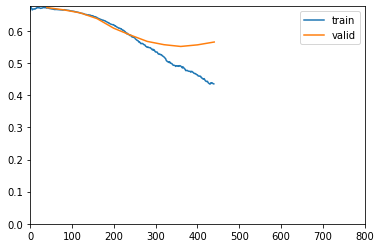

Better model found at epoch 1 with valid_loss value: 0.665647566318512.
Better model found at epoch 2 with valid_loss value: 0.6560667753219604.
Better model found at epoch 3 with valid_loss value: 0.638279914855957.
Better model found at epoch 4 with valid_loss value: 0.6083513498306274.
Better model found at epoch 5 with valid_loss value: 0.5869893431663513.
Better model found at epoch 6 with valid_loss value: 0.567378044128418.
Better model found at epoch 7 with valid_loss value: 0.5571970343589783.
Better model found at epoch 8 with valid_loss value: 0.5516977310180664.
No improvement since epoch 8: early stopping


In [12]:
learn.fine_tune(20,base_lr=1e-5)

In [13]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

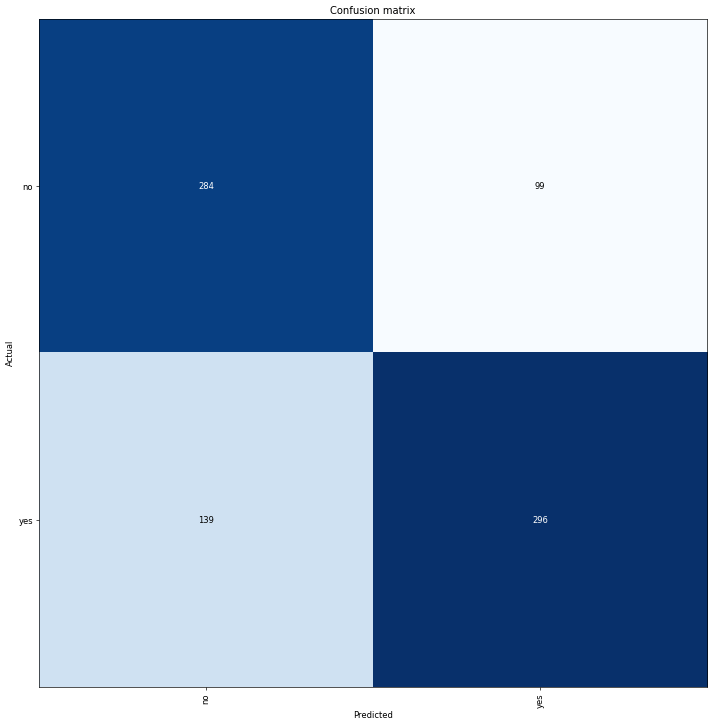

In [14]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [15]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.709046483039856.


(#4) [0.5619710683822632,0.709046483039856,0.7493670886075949,0.6804597701149425]

In [16]:
learn.export(fname='hrnet.pkl')